In [79]:
#Load data
from palmerpenguins import load_penguins
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO

penguins = load_penguins()

In [80]:
#preprocessing data
class_names = {}

for col in penguins.columns:
    if penguins[col].dtype == 'object':
        # Lưu lại tên các nhãn cho từng cột dạng chuỗi
        class_names[col] = penguins[col].unique().tolist()

# One-hot encoding cho tất cả các cột dạng object
penguins_encoded = pd.get_dummies(penguins, dummy_na=True)
feature = [col for col in penguins_encoded.columns if not col.startswith('species_')]
species = [col for col in penguins_encoded.columns if col.startswith('species_')]
X = penguins_encoded[feature]
Y = penguins_encoded[species]
Y_original = Y.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))

In [81]:
#function
def plot_class_distribution(labels, title, ax):
    sns.countplot(x=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")

In [82]:
#Train data 40/60
X_train_40_60, X_test_40_60, Y_train_40_60, Y_test_40_60 = train_test_split(
    X, Y,
    test_size=0.6,
    random_state=1,
    shuffle=True,
    stratify=Y
)
Y_train_40_60 = Y_train_40_60.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))
Y_test_40_60 = Y_test_40_60.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))

clf_40_60 = DecisionTreeClassifier(criterion='entropy')
clf_40_60 = clf_40_60.fit(X_train_40_60, Y_train_40_60)
Y_predict_40_60 = clf_40_60.predict(X_test_40_60)

Visualize dataset 40/60


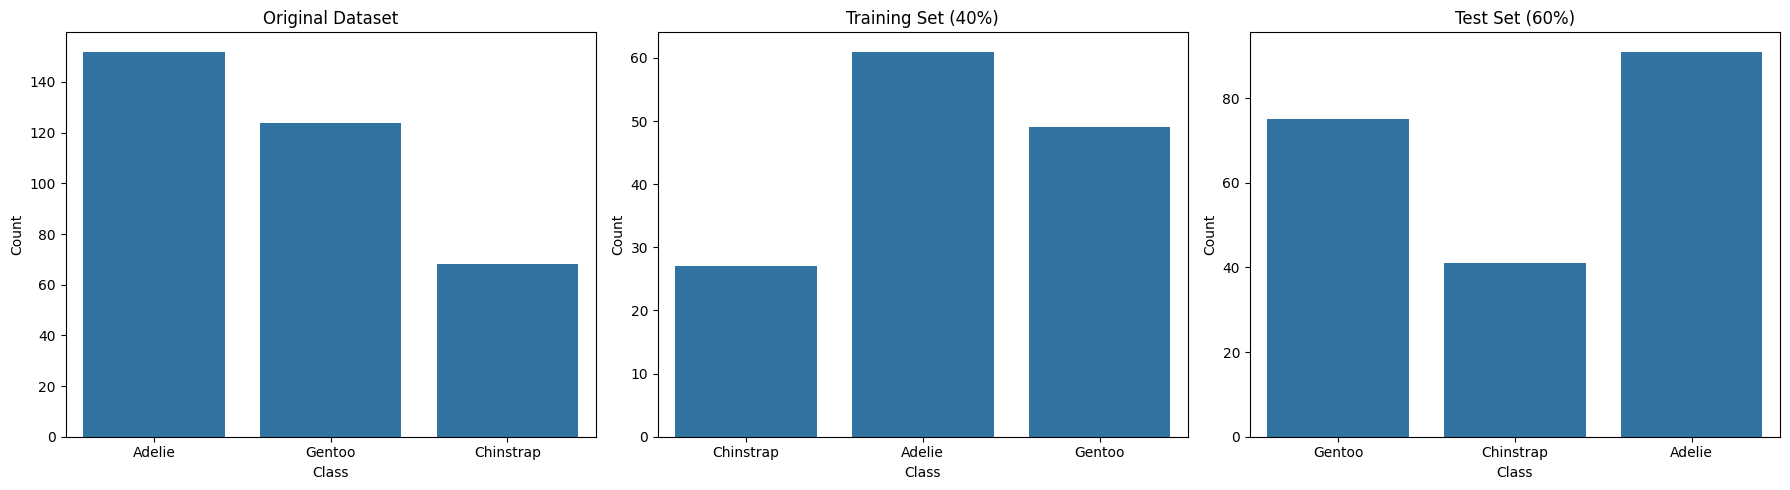

Accuracy: 0.961352657004831


In [83]:
# Visualize dataset 40/60
figure, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_class_distribution(Y_original, "Original Dataset", axes[0])
plot_class_distribution(Y_train_40_60, "Training Set (40%)", axes[1])
plot_class_distribution(Y_test_40_60, "Test Set (60%)", axes[2])

print(f"Visualize dataset 40/60")
plt.tight_layout()
plt.show()
print("Accuracy:",metrics.accuracy_score(Y_test_40_60, Y_predict_40_60))

In [84]:
# train data 60/40
X_train_60_40, X_test_60_40, Y_train_60_40, Y_test_60_40 = train_test_split(
    X, Y,
    test_size=0.4,
    random_state=1,
    shuffle=True,
    stratify=Y
)
Y_train_60_40 = Y_train_60_40.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))
Y_test_60_40 = Y_test_60_40.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))


clf_60_40 = DecisionTreeClassifier(criterion='entropy')
clf_60_40 = clf_60_40.fit(X_train_60_40, Y_train_60_40)
Y_predict_60_40 = clf_60_40.predict(X_test_60_40)
print("Accuracy:",metrics.accuracy_score(Y_test_60_40, Y_predict_60_40))

Accuracy: 0.9637681159420289


Visualize dataset 60/40


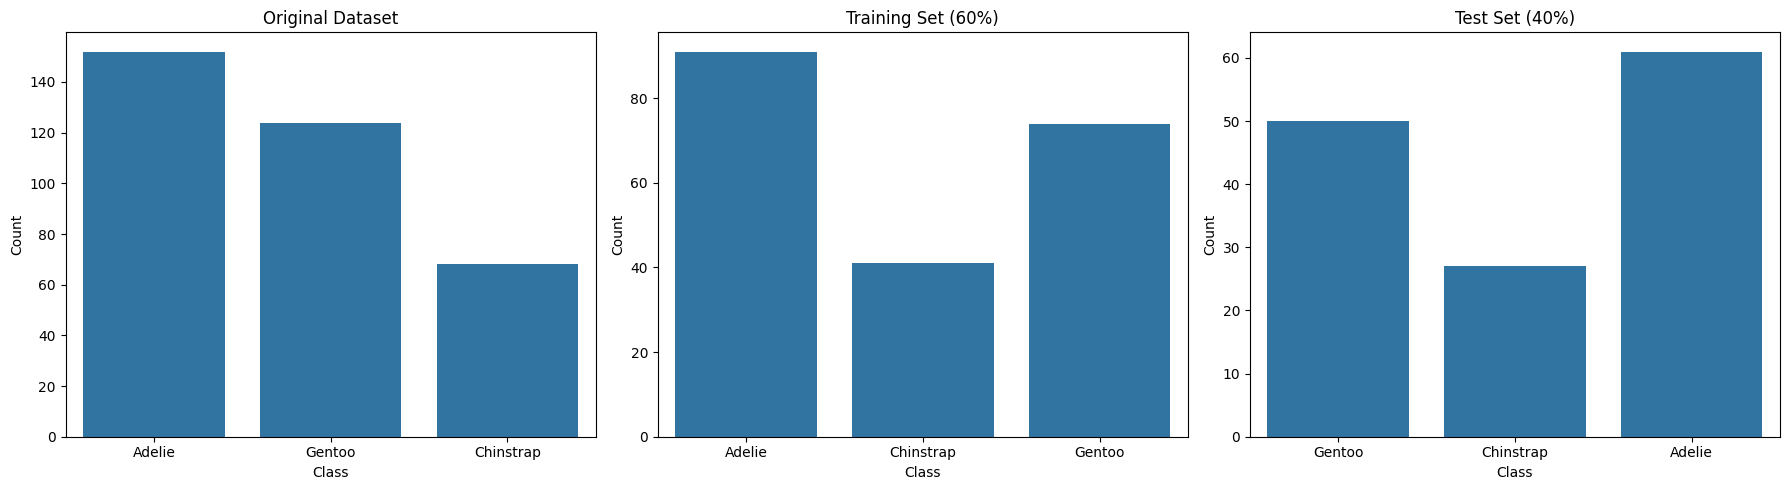

Accuracy: 0.9637681159420289


In [85]:
# Visualize dataset 60/40
figure, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_class_distribution(Y_original, "Original Dataset", axes[0])
plot_class_distribution(Y_train_60_40, "Training Set (60%)", axes[1])
plot_class_distribution(Y_test_60_40, "Test Set (40%)", axes[2])
print(f"Visualize dataset 60/40")
plt.tight_layout()
plt.show()
print("Accuracy:",metrics.accuracy_score(Y_test_60_40, Y_predict_60_40))

In [86]:
# Train data 80/20
X_train_80_20, X_test_80_20, Y_train_80_20, Y_test_80_20 = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=1,
    shuffle=True,
    stratify=Y
)
Y_train_80_20 = Y_train_80_20.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))
Y_test_80_20 = Y_test_80_20.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))


clf_80_20 = DecisionTreeClassifier(criterion='entropy')
clf_80_20 = clf_80_20.fit(X_train_80_20, Y_train_80_20)
Y_predict_80_20 = clf_80_20.predict(X_test_80_20)

Visualize dataset 80/20


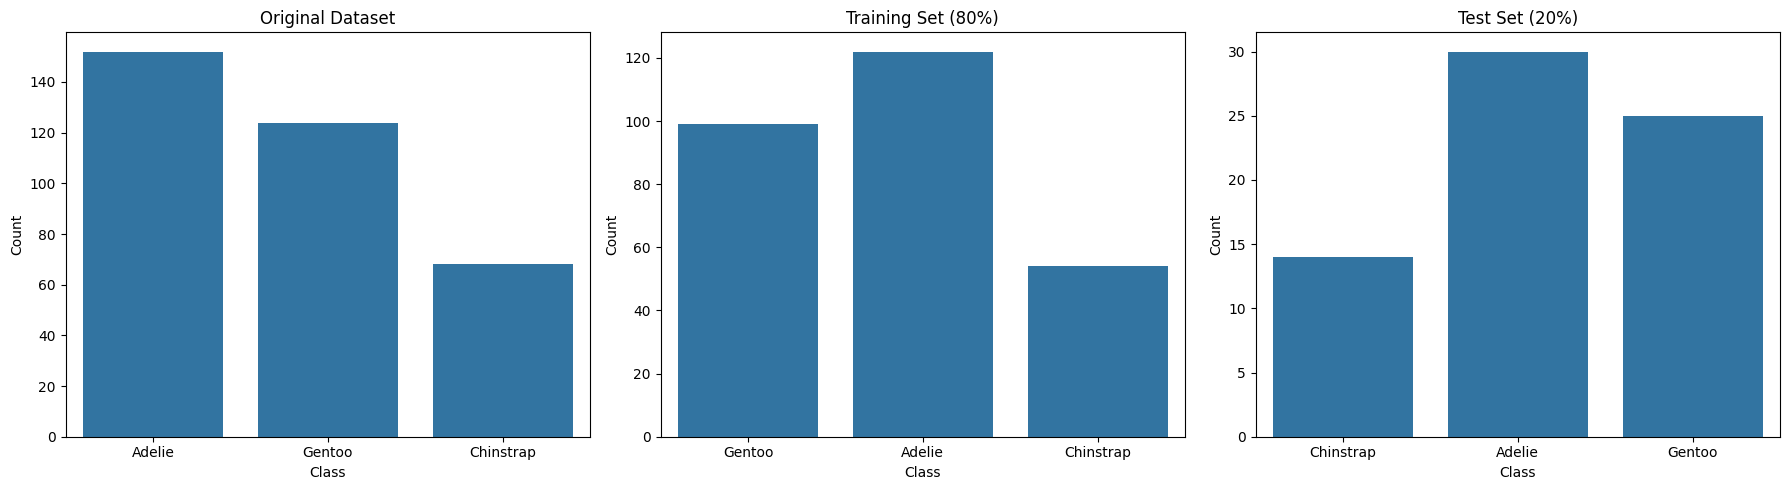

Accuracy: 0.9855072463768116


In [87]:
# Visualize dataset 80/20
figure, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_class_distribution(Y_original, "Original Dataset", axes[0])
plot_class_distribution(Y_train_80_20, "Training Set (80%)", axes[1])
plot_class_distribution(Y_test_80_20, "Test Set (20%)", axes[2])
print(f"Visualize dataset 80/20")
plt.tight_layout()
plt.show()
print("Accuracy:",metrics.accuracy_score(Y_test_80_20, Y_predict_80_20))


In [88]:
# Train data 90/10
X_train_90_10, X_test_90_10, Y_train_90_10, Y_test_90_10 = train_test_split(
    X, Y,
    test_size=0.1,
    random_state=1,
    shuffle=True,
    stratify=Y
)
Y_train_90_10 = Y_train_90_10.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))
Y_test_90_10 = Y_test_90_10.idxmax(axis=1).apply(lambda x: x.replace('species_', ''))


clf_90_10 = DecisionTreeClassifier(criterion='entropy')
clf_90_10 = clf_90_10.fit(X_train_90_10, Y_train_90_10)
Y_predict_90_10 = clf_90_10.predict(X_test_90_10)

Visualize dataset 90/10


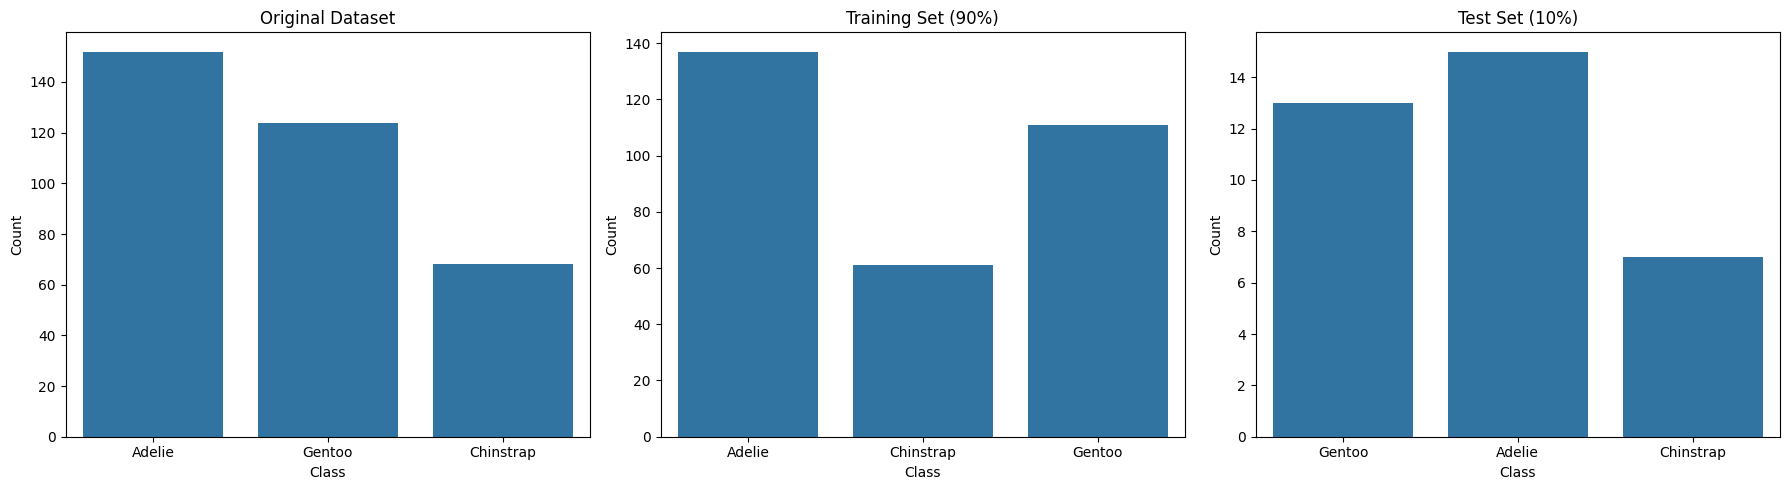

Accuracy: 0.9714285714285714


In [89]:
# Visualize dataset 90/10
figure, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_class_distribution(Y_original, "Original Dataset", axes[0])
plot_class_distribution(Y_train_90_10, "Training Set (90%)", axes[1])
plot_class_distribution(Y_test_90_10, "Test Set (10%)", axes[2])

print(f"Visualize dataset 90/10")
plt.tight_layout()
plt.show()
print("Accuracy:",metrics.accuracy_score(Y_test_90_10, Y_predict_90_10))

Decision tree with dataset 40/60


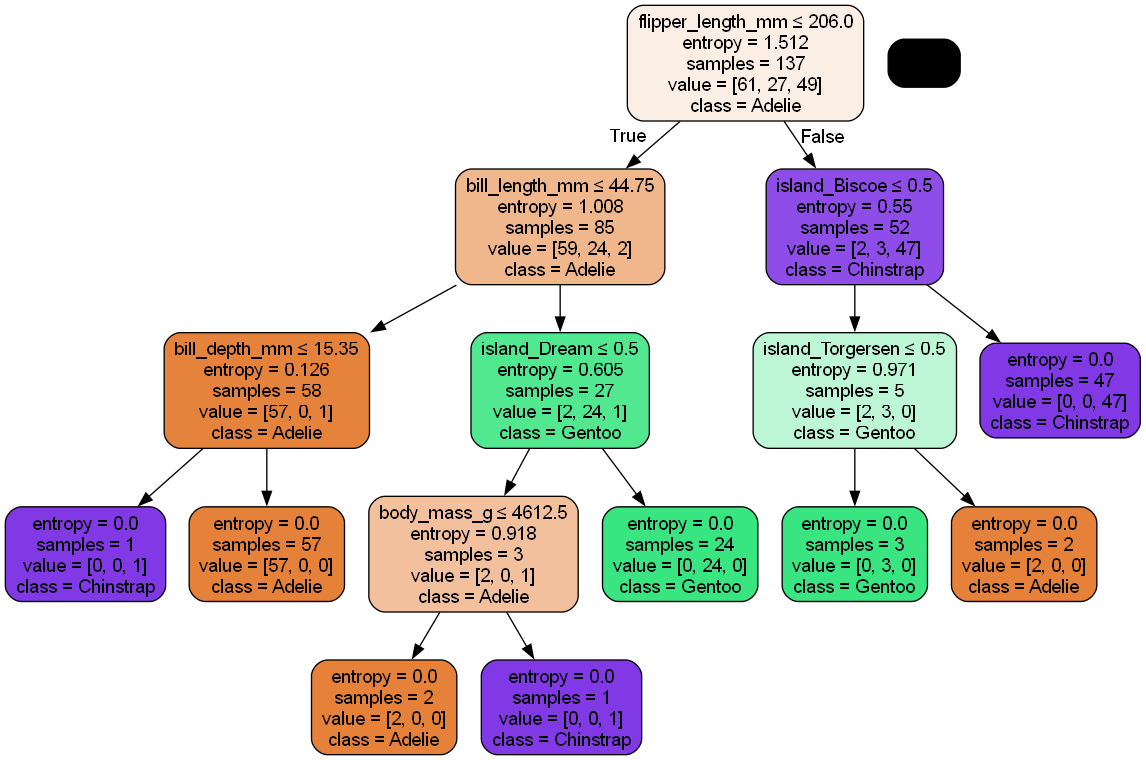

In [90]:
#Decision tree 40/60

dot_data = StringIO()
export_graphviz(clf_40_60, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_train_40_60.columns,
                class_names=class_names['species'])

print(f"Decision tree with dataset 40/60")
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())  # hiển thị trực tiếp trong notebook

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.93      0.99      0.96        91
   Chinstrap       0.97      0.85      0.91        41
      Gentoo       1.00      0.99      0.99        75

    accuracy                           0.96       207
   macro avg       0.97      0.94      0.95       207
weighted avg       0.96      0.96      0.96       207

Confusion Matrix (Depth=4, 40/60 split):



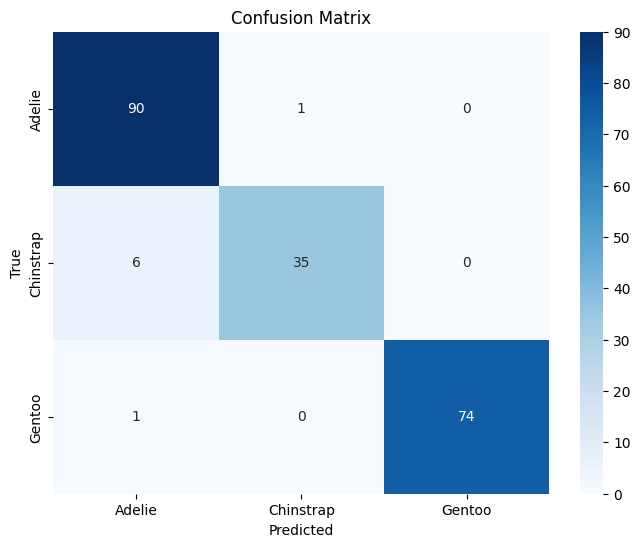

In [91]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(Y_test_40_60, Y_predict_40_60))

print(f"Confusion Matrix (Depth={clf_40_60.tree_.max_depth}, 40/60 split):\n")
cm = confusion_matrix(Y_test_40_60, Y_predict_40_60)
# Plotting confusion matrix as a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf_40_60.classes_, yticklabels=clf_40_60.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Decision tree with dataset 60/40


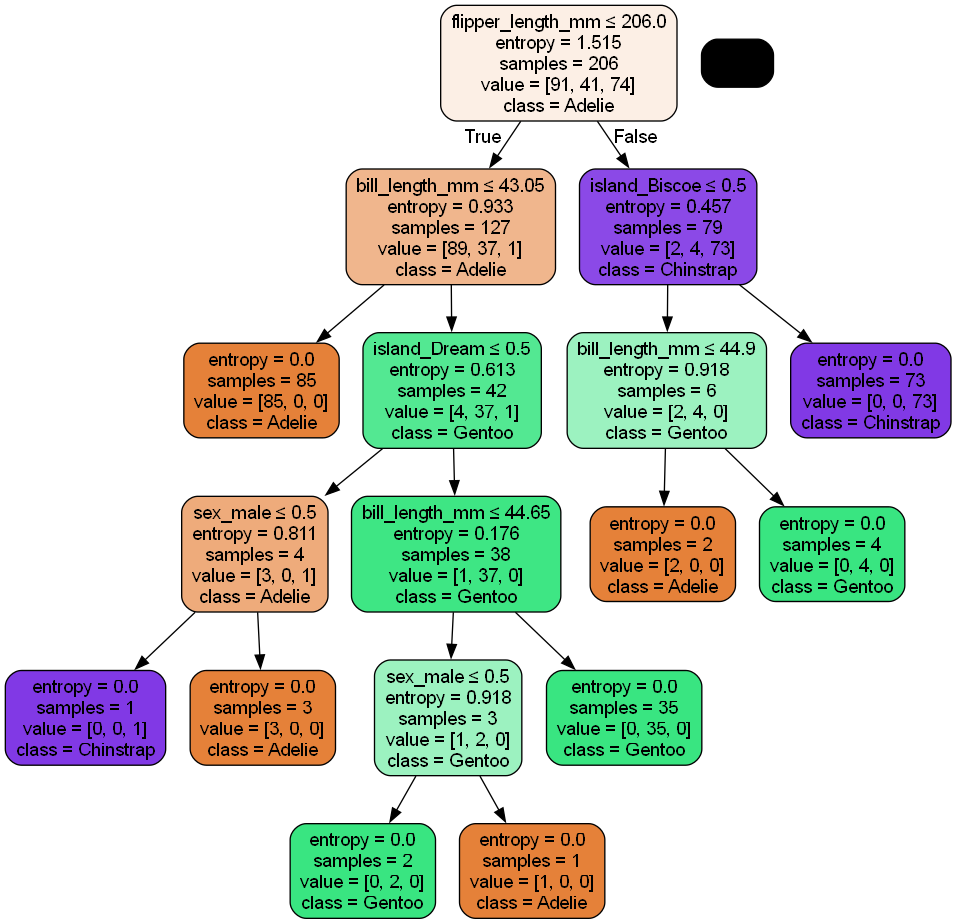

In [92]:
#Decision tree 40/60
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO

dot_data = StringIO()
export_graphviz(clf_60_40, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_train_60_40.columns,
                class_names=class_names['species'])
print(f"Decision tree with dataset 60/40")
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())  # hiển thị trực tiếp trong notebook

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.92      1.00      0.96        61
   Chinstrap       1.00      0.85      0.92        27
      Gentoo       1.00      0.98      0.99        50

    accuracy                           0.96       138
   macro avg       0.97      0.94      0.96       138
weighted avg       0.97      0.96      0.96       138

Confusion Matrix (Depth=5, 60/40 split):



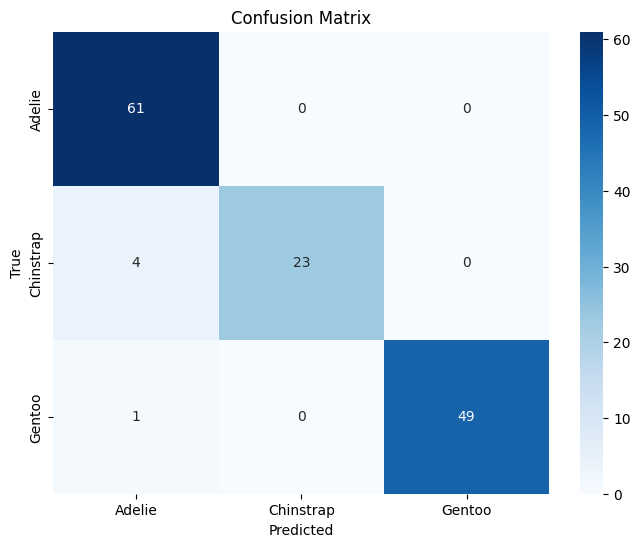

In [93]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(Y_test_60_40, Y_predict_60_40))

print(f"Confusion Matrix (Depth={clf_60_40.tree_.max_depth}, 60/40 split):\n")
cm = confusion_matrix(Y_test_60_40, Y_predict_60_40)
# Plotting confusion matrix as a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf_60_40.classes_, yticklabels=clf_60_40.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Decision tree with dataset 80/20


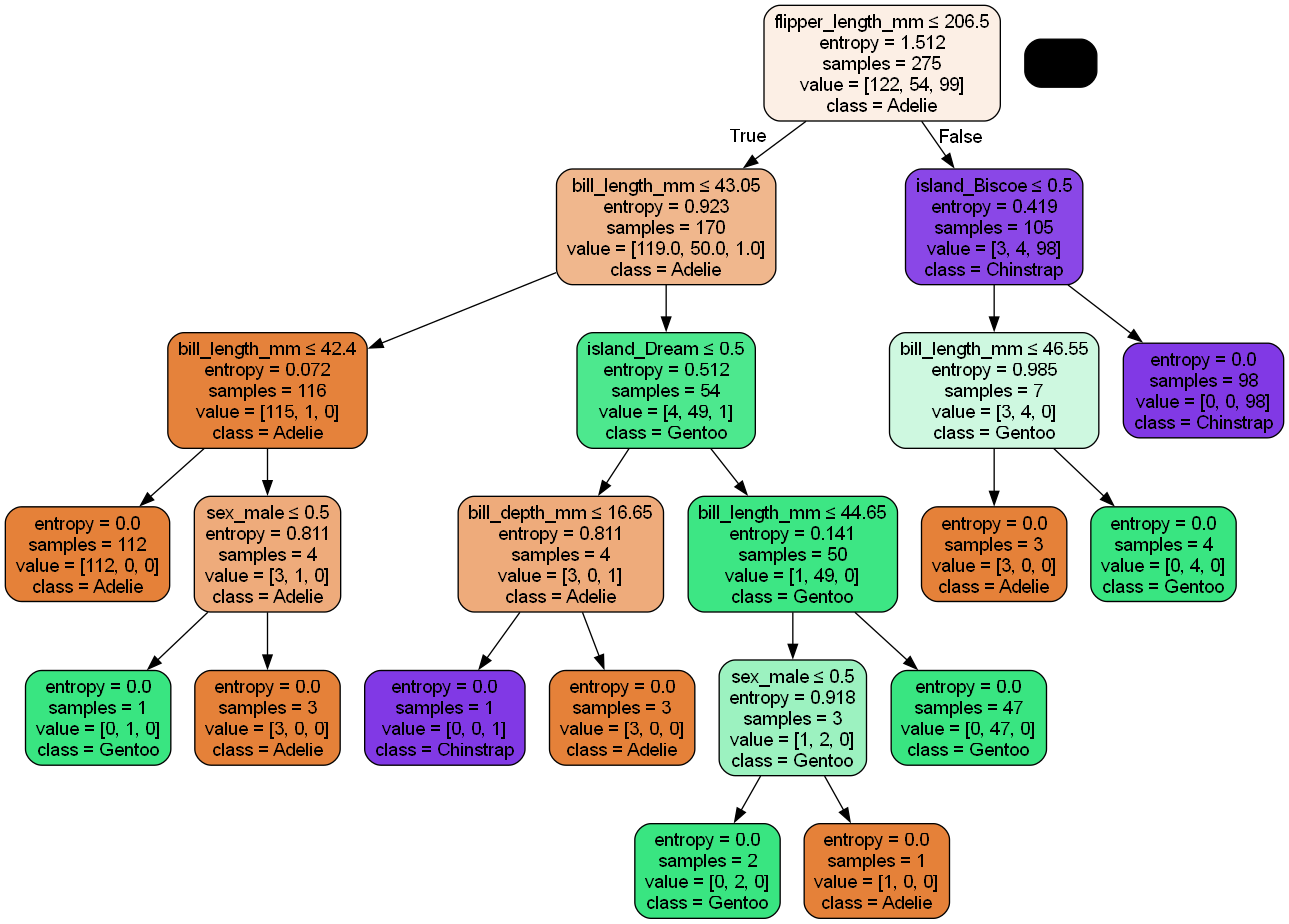

In [94]:
#Decision tree 80/20
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO

dot_data = StringIO()
export_graphviz(clf_80_20, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_train_80_20.columns,
                class_names=class_names['species'])
print(f"Decision tree with dataset 80/20")
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())  # hiển thị trực tiếp trong notebook

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.97      1.00      0.98        30
   Chinstrap       1.00      0.93      0.96        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69

Confusion Matrix (Depth=5, 80/20 split):



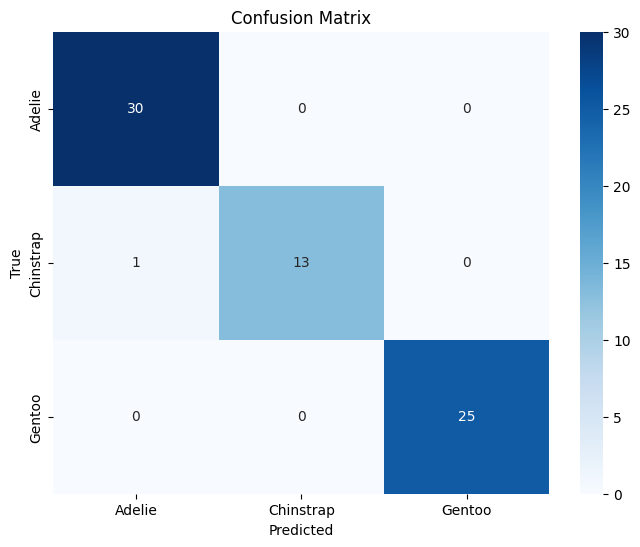

In [95]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(Y_test_80_20, Y_predict_80_20))

print(f"Confusion Matrix (Depth={clf_80_20.tree_.max_depth}, 80/20 split):\n")
cm = confusion_matrix(Y_test_80_20, Y_predict_80_20)
# Plotting confusion matrix as a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf_80_20.classes_, yticklabels=clf_80_20.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Decision tree with dataset 90/10


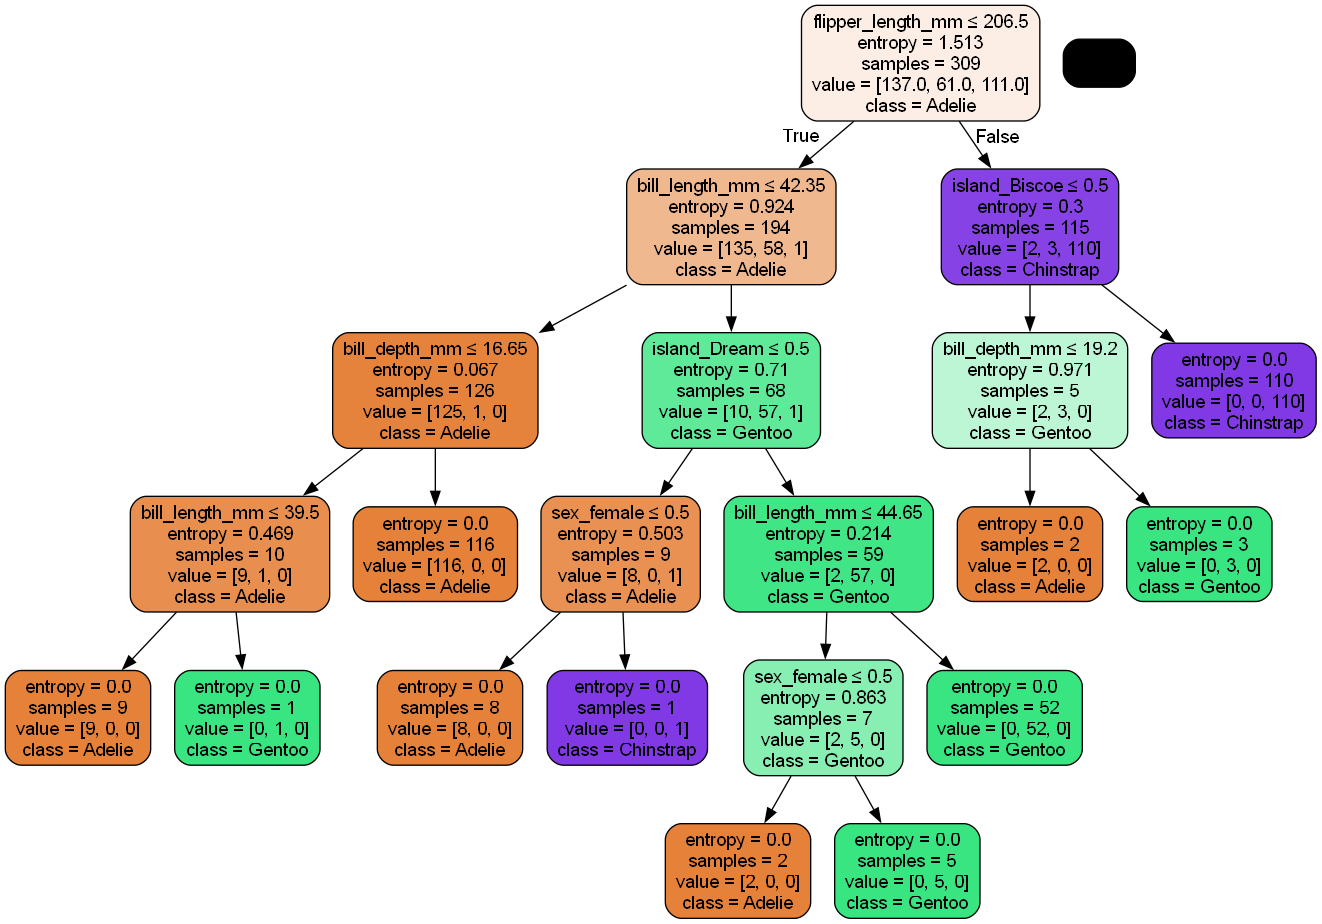

In [96]:
#Decision tree 90/10
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO

dot_data = StringIO()
export_graphviz(clf_90_10, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_train_90_10.columns,
                class_names=class_names['species'])
print(f"Decision tree with dataset 90/10")
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())  # hiển thị trực tiếp trong notebook

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        15
   Chinstrap       1.00      0.86      0.92         7
      Gentoo       1.00      1.00      1.00        13

    accuracy                           0.97        35
   macro avg       0.98      0.95      0.96        35
weighted avg       0.97      0.97      0.97        35

Confusion Matrix (Depth=5, 90/10 split):



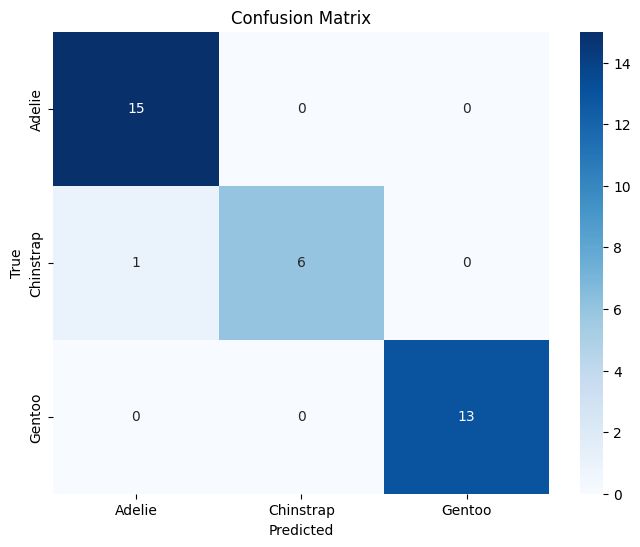

In [97]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(Y_test_90_10, Y_predict_90_10))

print(f"Confusion Matrix (Depth={clf_90_10.tree_.max_depth}, 90/10 split):\n")
cm = confusion_matrix(Y_test_90_10, Y_predict_90_10)
# Plotting confusion matrix as a heatmap for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf_90_10.classes_, yticklabels=clf_90_10.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [98]:
#Prepare dataset 80/20 for each depth
max_depth = [None, 2, 3, 4, 5, 6, 7]
accuracies = []
trees = {}

for depth in max_depth:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=1)
    clf.fit(X_train_80_20, Y_train_80_20)
    Y_predict = clf.predict(X_test_80_20)
    
    accuracies.append(metrics.accuracy_score(Y_test_80_20, Y_predict))
    trees[depth] = clf

Decision Tree (max_depth=None)


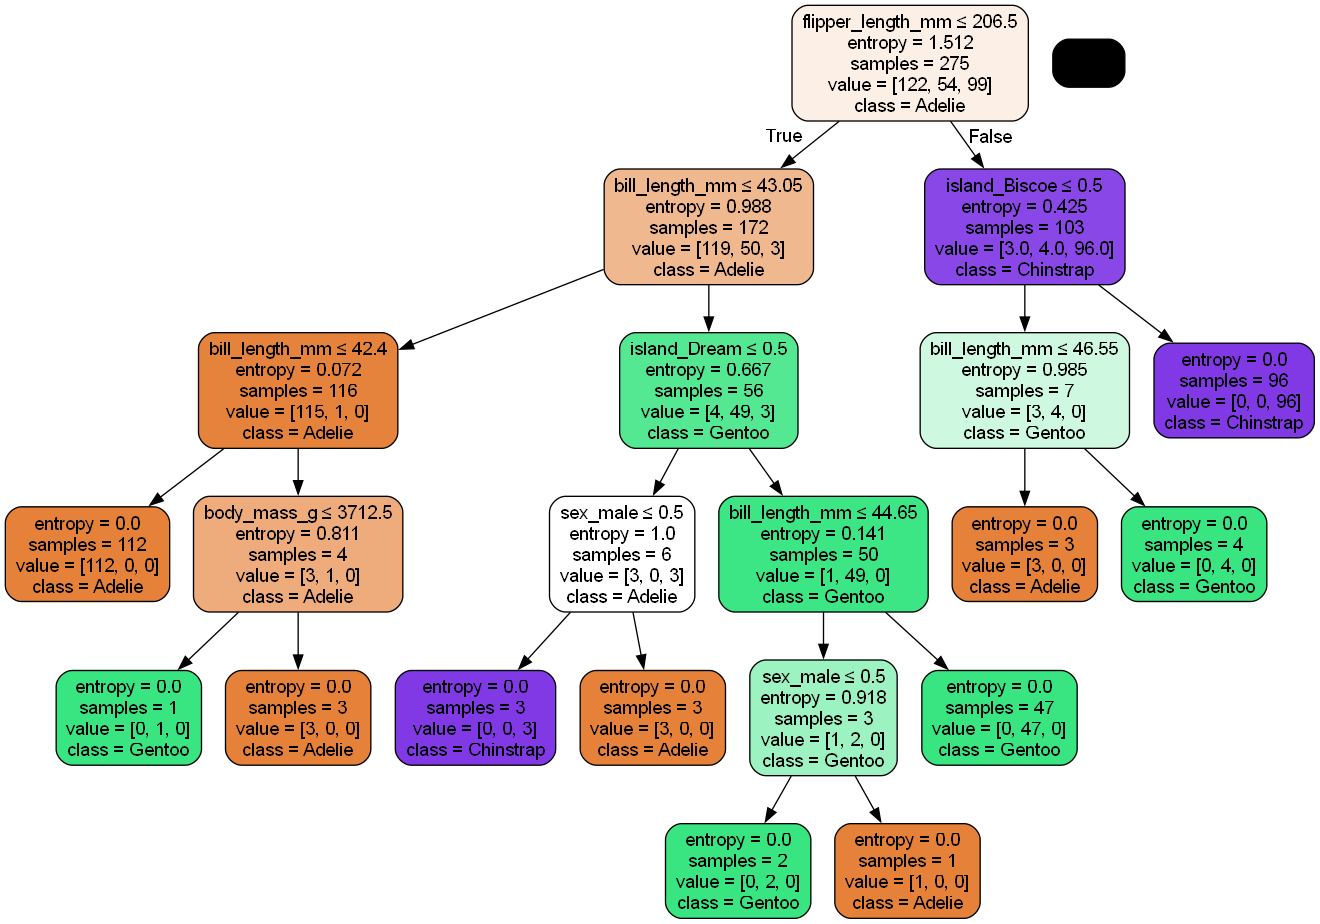

Decision Tree (max_depth=2)


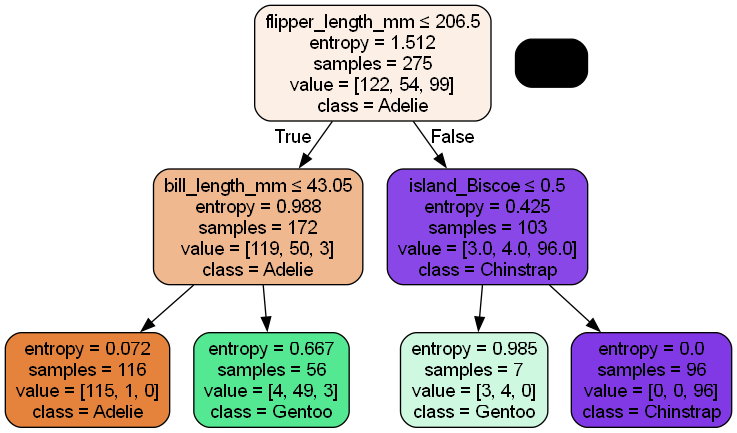

Decision Tree (max_depth=3)


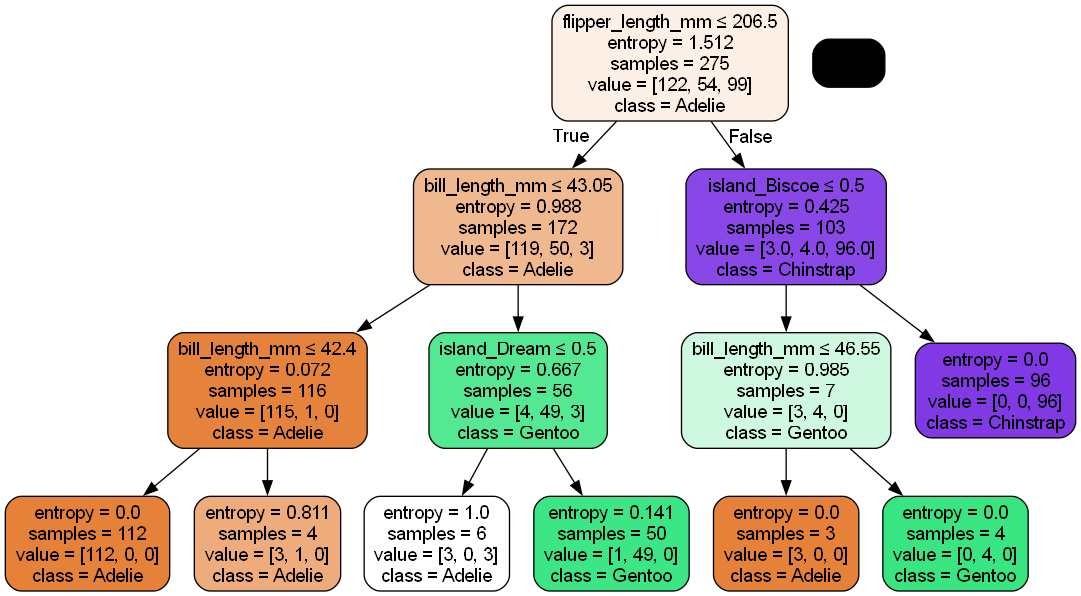

Decision Tree (max_depth=4)


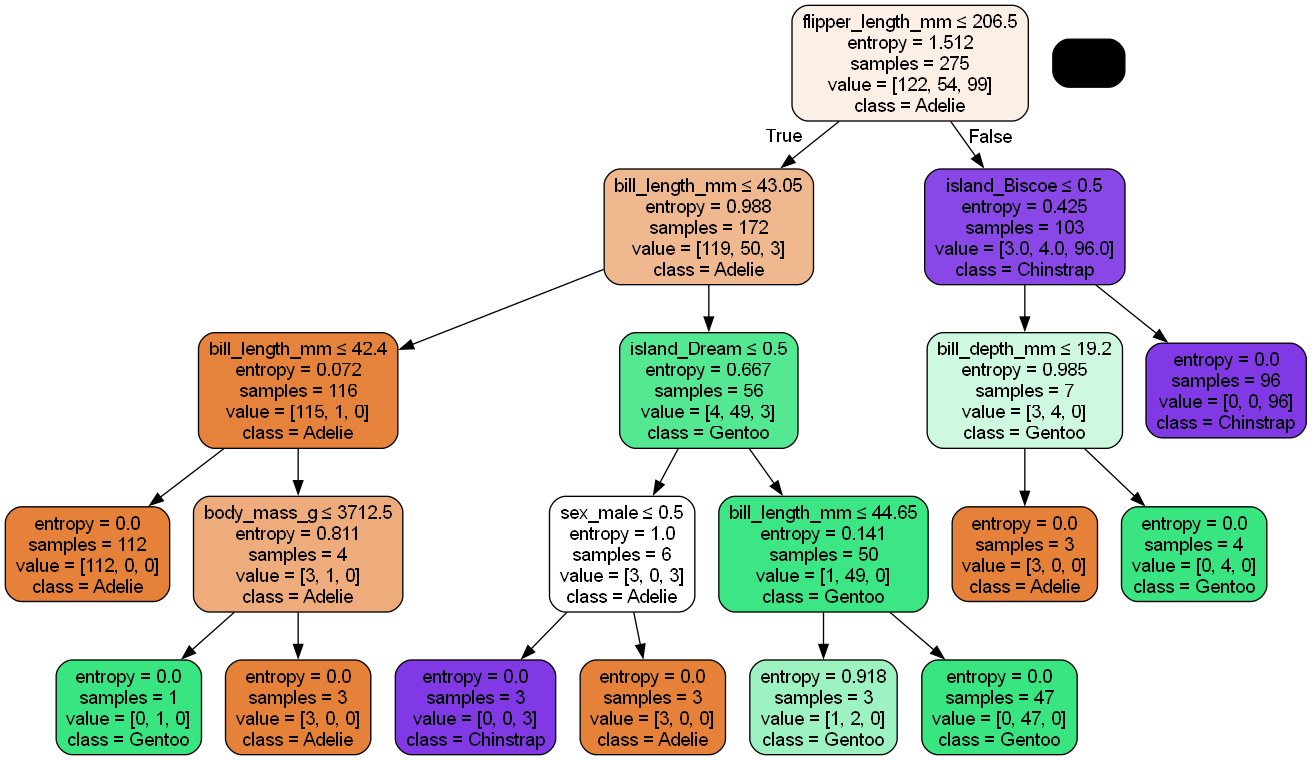

Decision Tree (max_depth=5)


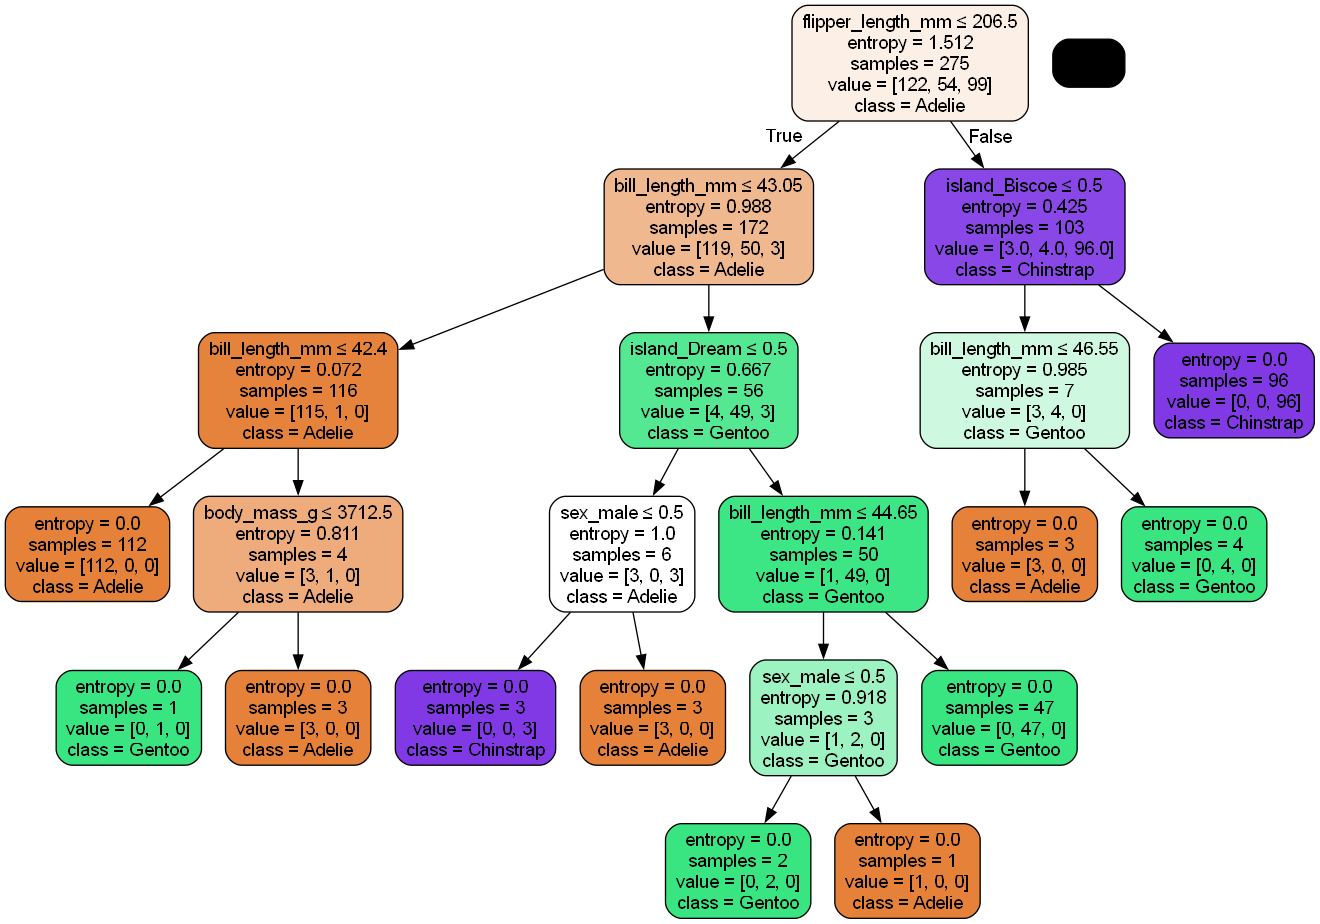

Decision Tree (max_depth=6)


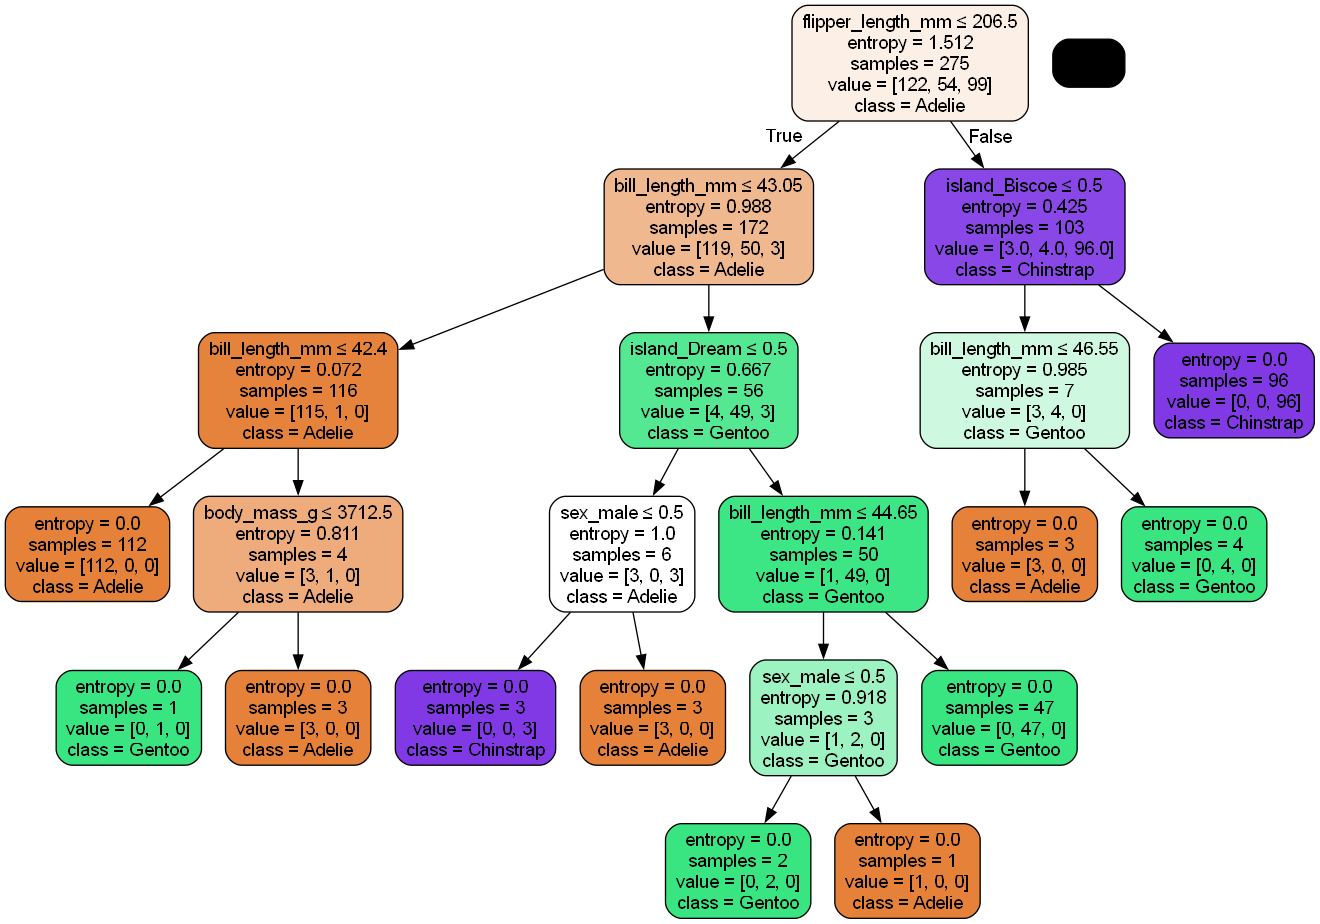

Decision Tree (max_depth=7)


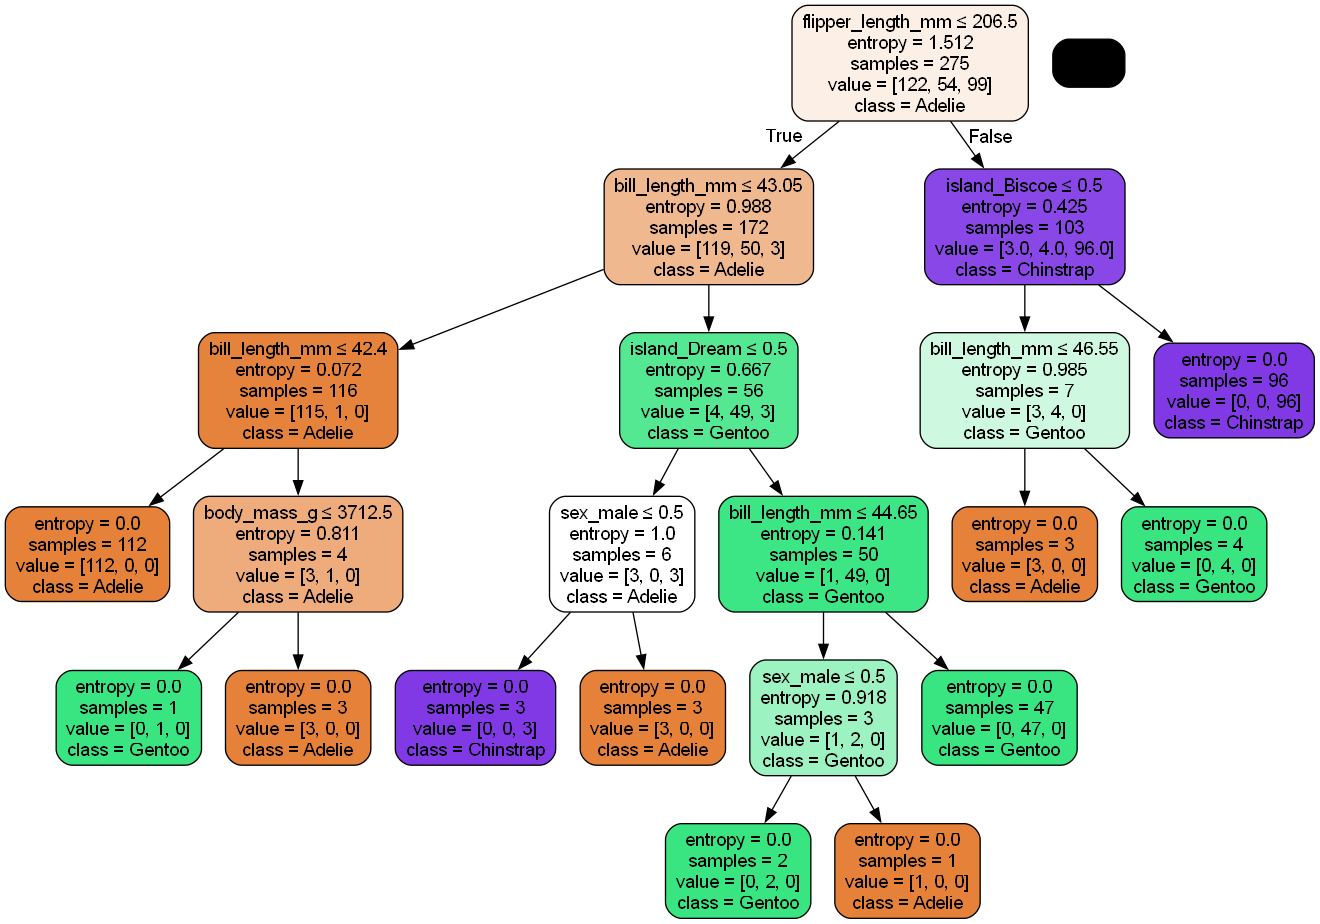

In [99]:
#Decision tree 80/20
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO

for depth in max_depth:
    dot_data = StringIO()   
    export_graphviz(trees[depth], out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,
                    feature_names=X_train_80_20.columns,
                    class_names=class_names['species'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    print(f"Decision Tree (max_depth={depth})")
    display(Image(graph.create_png()))  # hiển thị đúng trong notebook



In [103]:
results = pd.DataFrame({
    'max_depth': ['None'] + max_depth[1:],
    'Accuracy': accuracies
})
results = results.set_index("max_depth").T
print(results.to_string())

max_depth      None         2         3         4         5         6         7
Accuracy   0.985507  0.913043  0.942029  0.956522  0.985507  0.985507  0.985507
